In [1]:
import numpy as np
from traj_opt import TrajOpt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import time
from mobile_navigation_task import mobile_navigation_task as Task, Human

%load_ext autoreload
%autoreload 2

In [2]:
task = Task()

### Basis functions. Providing Phi_T, Rw

OBF

In [3]:
to = TrajOpt(task.ndof)

### Sequential least-squares quadratic programming

In [4]:
def fun(p):
    w = np.concatenate((task.q_0, p, task.q_d, task.dq_0, np.zeros(task.ndof)))
    return task.alpha_control * task.control_cost(w)

def obstacle_con_p(p):
    return task.get_dist_vec(np.concatenate((task.q_0, p, task.q_d, task.dq_0, np.zeros(task.ndof))))

In [5]:
def run_opt(num_basis, p_init=None):
    nw = num_basis + 4
    num_via = num_basis + 1
    h = task.T * np.ones(num_via) / num_via
    to.setup_task(h)

    Phi = to.get_Phi(task.t_cost_array)
    dPhi = to.get_dPhi(task.t_cost_array)
    ddPhi = to.get_ddPhi(task.t_cost_array)

    task.set_basis(Phi, dPhi, ddPhi)

    Xi = np.zeros((nw*task.ndof, num_basis*task.ndof))
    Xi[task.ndof:-3*task.ndof] = np.eye(num_basis*task.ndof)

    def grad(p):
        w = np.concatenate((task.q_0, p, task.q_d, task.dq_0, np.zeros(task.ndof)))
        return (task.alpha_control * task.control_grad(w)) @ Xi


    constraints = []
    if len(task.t_cost_array) > 2:
        dq_off = dPhi[task.ndof:-task.ndof, :task.ndof] @ task.q_0 + dPhi[task.ndof:-task.ndof, -3*task.ndof:-2*task.ndof] @ task.q_d + dPhi[task.ndof:-task.ndof, -2*task.ndof:-task.ndof] @ task.dq_0
        constraints.append(LinearConstraint(dPhi[task.ndof:-task.ndof, task.ndof:-3*task.ndof],  -task.dq_lim-dq_off, task.dq_lim-dq_off))
    constraints.append(NonlinearConstraint(obstacle_con_p, task.r_obs_sq-1e-3, np.inf))

    if p_init is None:
        p_init = np.zeros(num_basis*task.ndof)
        for i in range(num_basis):
            p_init[i*task.ndof:(i+1)*task.ndof] = (num_basis - i - 0.5) / num_basis * task.q_0 + (i + 0.5) / num_basis * task.q_d + np.random.normal(0, 0.5, task.ndof)

    start = time.time()
    res = minimize(fun, p_init, method='SLSQP', jac=grad, bounds=None, constraints=constraints, options={'maxiter': 30, 'ftol': 1e-6, 'disp': False})
    duration = time.time()-start
    #print("Elapsed time: ", duration," [s]")
    return res.success, res.fun, np.concatenate((task.q_0, res.x, task.q_d, task.dq_0, np.zeros(task.ndof))), duration

In [6]:
human_list = []
for i in range(20):
    human = Human(np.random.uniform(0.5, 5.5, size=2), np.random.randint(0,16), np.random.uniform(), task.dt_planning)
    human_list.append(human)

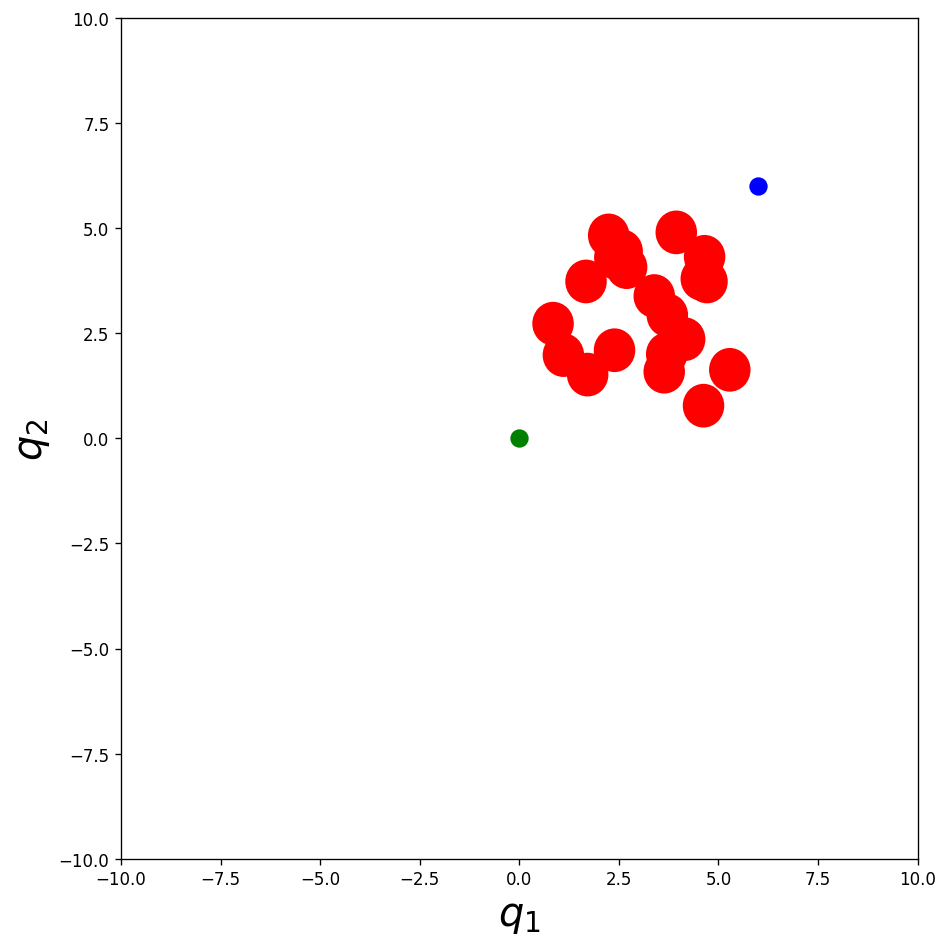

In [7]:
task.q_0 = np.array([6.0, 6.0])
task.q_d = np.array([0.0, 0.0])
task.dq_0 = np.array([0.0, 0.0])

obs_list = []
for h in human_list:
    obs_list.append(h.x)
task.set_obstacle_list(obs_list)
task.plot_environment(None)

In [8]:
task.q_0 = np.array([6.0, 6.0])
task.q_d = np.array([0.0, 0.0])
task.dq_0 = np.array([0.0, 0.0])
task.set_time(15.0)
task.set_obstacle_list([])
task.set_dyn_obstacle_list([])

q_list = []
dq_list = []
ddq_list = []
q_list.append(task.q_0)
dq_list.append(task.dq_0)
ddq_list.append(np.zeros(2))

k = 0
success = False
while task.T > task.dt_planning/2.0:
    task.q_0 = q_list[k]
    task.dq_0 = dq_list[k]

    # randomly change direction
    sel = np.random.randint(0, 5*len(human_list))
    if sel < len(human_list):
        human_list[sel].dir += np.random.randint(-3,3)
        if human_list[sel].dir < 0:
            human_list[sel].dir += 16
        if human_list[sel].dir > 15:
            human_list[sel].dir -= 16

    obs_list = []
    for h in human_list:
        obs_list.append(h.predict(task.t_cost_array)[1:-1])
    task.set_dyn_obstacle_list(obs_list)
    
    if success == False:
        num_basis = 1
        beta = 1.5
        T = 0
        while num_basis < 15:
            #print(num_basis)
            success, f, w_opt, duration = run_opt(num_basis)
            T += duration
            if success:
                break
            num_basis = int(np.ceil(num_basis*beta))
    else:
        success, f, w_opt, T = run_opt(num_basis, w_opt[task.ndof:-3*task.ndof])

    print(success, f, T, task.T)
    if success == True:
        q_list.append(to.get_Phi(task.dt_planning) @ w_opt)
        dq_list.append(to.get_dPhi(task.dt_planning) @ w_opt)
        ddq_list.append(to.get_ddPhi(task.dt_planning) @ w_opt)
        task.set_time(task.T - task.dt_planning)
        for h in human_list:
            h.step()
        k += 1
    else:
        K_false = np.max([1, int(T/task.dt_planning)])
        for k_ in range(K_false):
            q_list.append(q_list[k])
            dq_list.append(np.zeros(2))
            ddq_list.append(np.zeros(2))
            for h in human_list:
                h.step()
        k += K_false
        task.set_time(task.T + task.dt_planning)

T_dur = k * task.dt_planning

q_list = np.array(q_list)
dq_list = np.array(dq_list)
ddq_list = np.array(ddq_list)

True 0.01358973590128319 0.028639793395996094 15.0
True 0.013398423262484017 0.007480621337890625 14.95
True 0.013303182836074394 0.010349512100219727 14.9
True 0.013171765616321857 0.005839109420776367 14.85
True 0.013045840367771663 0.008941650390625 14.8
True 0.01292872510220858 0.007111787796020508 14.75
True 0.0127744507536942 0.007483005523681641 14.7
True 0.012713322399559454 0.0073490142822265625 14.65
True 0.01261411401386242 0.006159305572509766 14.6
True 0.012481212520164769 0.021232128143310547 14.55
True 0.012366800134545233 0.008732795715332031 14.5
True 0.012217972421610329 0.008216619491577148 14.45
True 0.012159635852755767 0.009890317916870117 14.4
True 0.012067045715675845 0.0075092315673828125 14.35
True 0.01197962885355303 0.008657693862915039 14.3
True 0.011852829455334833 0.017901897430419922 14.25
True 0.011709290420564683 0.0074024200439453125 14.2
True 0.011655817116701862 0.007692575454711914 14.15
True 0.011568566727184475 0.007619619369506836 14.1
True 0.01

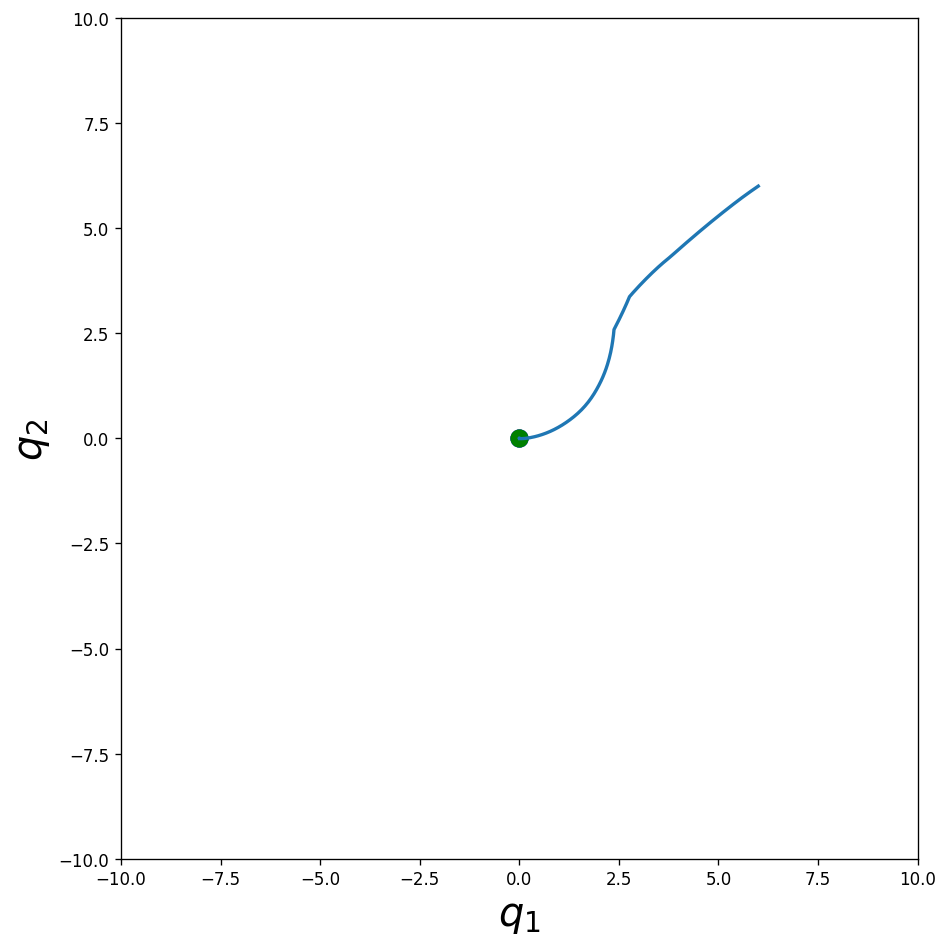

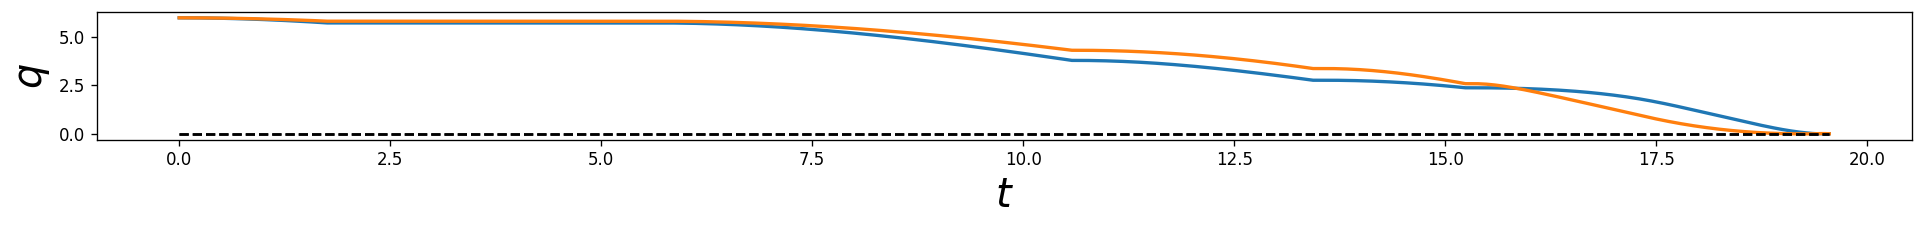

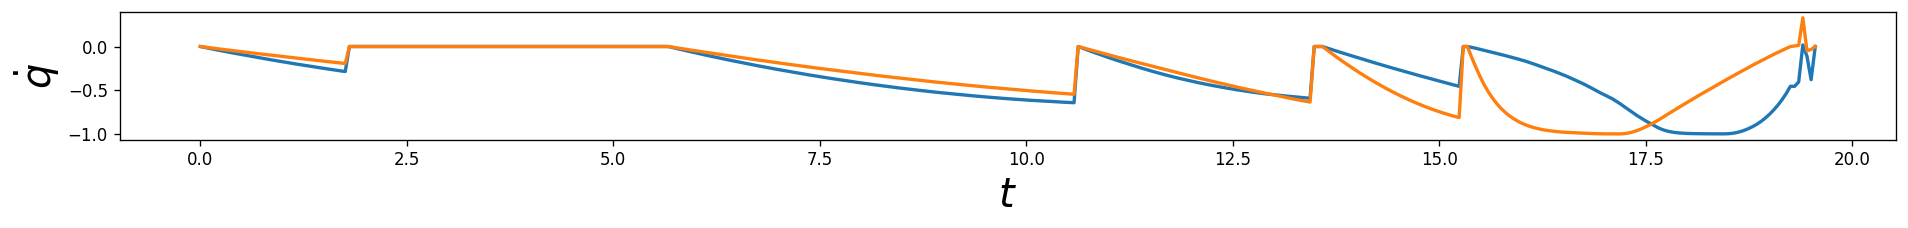

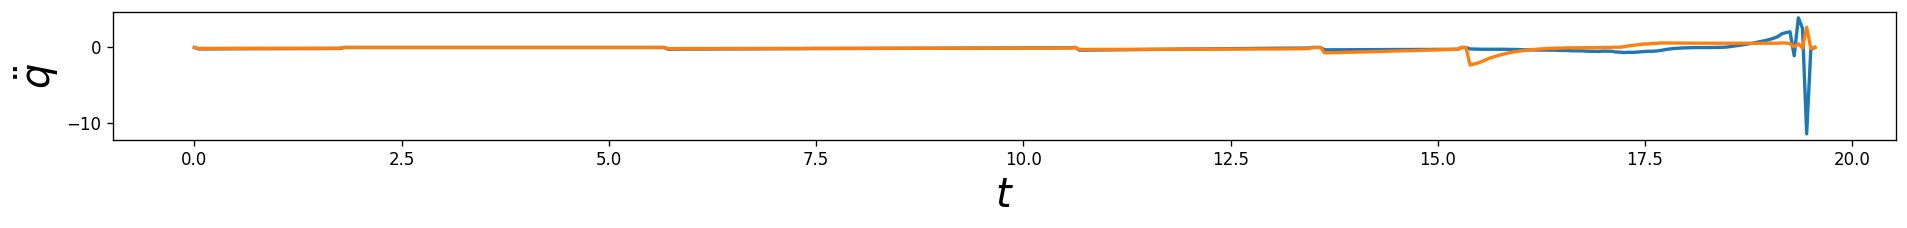

In [9]:
task.plot_environment(q_list)
task.plot_q(q_list)
task.plot_dq(dq_list)
task.plot_ddq(ddq_list)

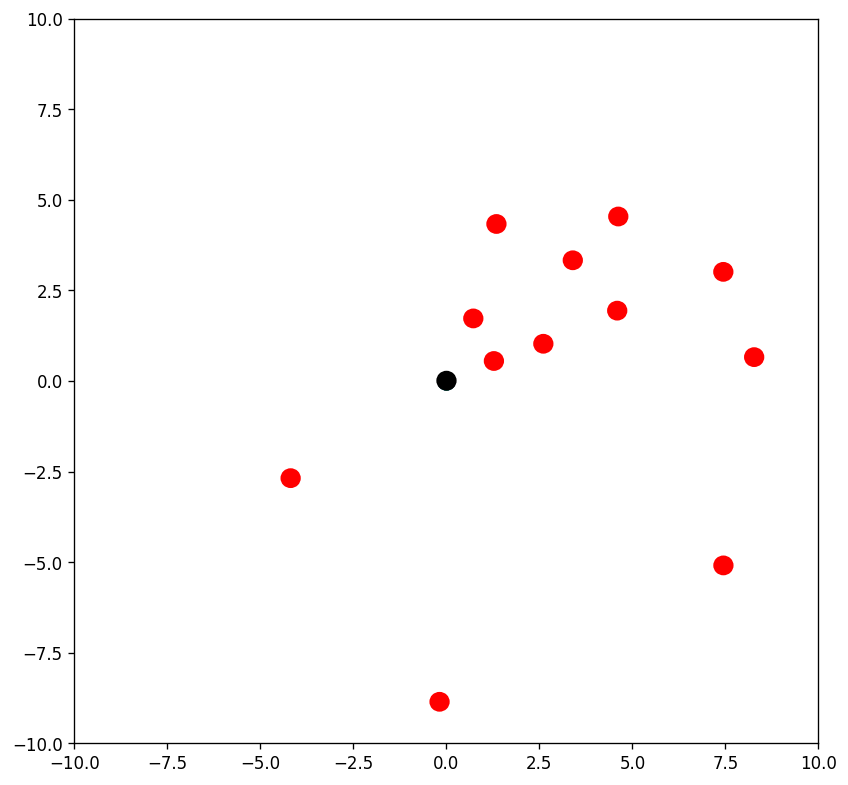

In [10]:
task.set_obstacle_list([])
dyn_obs_list = []
for h in human_list:
    dyn_obs_list.append(np.array(h.trajectory))
task.set_dyn_obstacle_list(dyn_obs_list)
task.T = T_dur
task.save_animation(q_list)